## Importación de librerías y configuración inicial

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
from dotenv import load_dotenv

load_dotenv()

BASE_URL = os.getenv("COINGECKO_BASE_URL")
API_KEY = os.getenv("COINGECKO_API_KEY")
DEFAULT_CURRENCY = os.getenv("DEFAULT_VS_CURRENCY")

print("Configuración cargada correctamente")

Configuración cargada correctamente


## Función para obtener datos desde CoinGecko

In [3]:
def get_coin_data_api(coin_id: str, symbol: str, days: int | str = 180) -> pd.DataFrame:
    url = f"{BASE_URL}/coins/{coin_id}/market_chart"
    params = {"vs_currency": DEFAULT_CURRENCY, "days": days, "x_cg_demo_api_key": API_KEY}

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Convertir las tres listas a DataFrames
    df_price = pd.DataFrame(data["prices"], columns=["timestamp", "close"])
    df_cap = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
    df_vol = pd.DataFrame(data["total_volumes"], columns=["timestamp", "volume"])

    # Fusionar
    df = df_price.merge(df_cap, on="timestamp").merge(df_vol, on="timestamp")

    # Procesamiento
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms").dt.date
    df["coin"] = symbol
    df["open"] = df["close"]
    df["high"] = df["close"]
    df["low"] = df["close"]
    df["source"] = "API"

    return df[["date", "coin", "open", "high", "low", "close", "volume", "market_cap", "source"]]


## Función para cargar datasets locales (CSV)

In [4]:
def load_csv(path: str, symbol: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Renombrar columnas comunes
    rename_map = {
        "Date": "date", "Open": "open", "High": "high", "Low": "low",
        "Close": "close", "Volume": "volume", "Marketcap": "market_cap"
    }
    df.rename(columns=rename_map, inplace=True)

    # Asegurar tipos correctos
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["coin"] = symbol
    df["source"] = "CSV"

    # Mantener solo columnas del esquema
    cols = ["date", "coin", "open", "high", "low", "close", "volume", "market_cap", "source"]
    for col in cols:
        if col not in df.columns:
            df[col] = None

    return df[cols]


## Función para eliminar nulos y duplicados

In [ ]:
def limpiar_datos(df: pd.DataFrame, nombre: str = "Dataset") -> pd.DataFrame:

    print(f"\n Limpieza de datos para: {nombre}")
    print("-" * 60)

    registros_iniciales = len(df)

    # Eliminar duplicados por 'coin' + 'date' si existen
    if "date" in df.columns and "coin" in df.columns:
        df = df.drop_duplicates(subset=["coin", "date"])
    else:
        df = df.drop_duplicates()

    # Eliminar filas completamente vacías o con valores nulos críticos
    df = df.dropna(subset=["close"], how="any")

    # Si una columna entera es nula, la eliminamos
    df = df.dropna(axis=1, how="all")

    registros_finales = len(df)
    eliminados = registros_iniciales - registros_finales

    print(f"Registros iniciales: {registros_iniciales:,}")
    print(f"Registros eliminados: {eliminados:,}")
    print(f"Registros finales: {registros_finales:,}")

    print("Limpieza completada.")
    print("-" * 60)
    return df.reset_index(drop=True)

## Función para validar la limpieza de los datos

In [6]:
def validar_calidad_datos(df: pd.DataFrame, nombre: str = "Dataset") -> None:

    print(f"\n Validación de calidad de datos para: {nombre}")
    print("-" * 60)

    # Número total de registros
    total = len(df)
    print(f"Total de registros: {total:,}")

    # Nulos por columna
    nulos = df.isnull().sum()
    nulos_totales = nulos.sum()

    if nulos_totales == 0:
        print("No hay valores nulos.")
    else:
        print("Se encontraron valores nulos:")
        print(nulos[nulos > 0])

    # Duplicados
    if "date" in df.columns and "coin" in df.columns:
        duplicados = df.duplicated(subset=["coin", "date"]).sum()
        print(f"Registros duplicados (por coin + date): {duplicados}")
    else:
        duplicados = df.duplicated().sum()
        print(f"Registros duplicados (por fila completa): {duplicados}")

    # Resultado general
    if nulos_totales == 0 and duplicados == 0:
        print("Dataset limpio y listo para análisis.")
    else:
        print("Es recomendable limpiar los datos antes de continuar.")

    print("-" * 60)

## Obtener y limpiar los datos (API + CSV)

In [7]:
btc_api = get_coin_data_api("bitcoin", "BTC")
eth_api = get_coin_data_api("ethereum", "ETH")
bnb_api = get_coin_data_api("binancecoin", "BNB")


btc_csv = load_csv("../data/raw/coin_Bitcoin.csv", "BTC")
eth_csv = load_csv("../data/raw/coin_Ethereum.csv", "ETH")
bnb_csv = load_csv("../data/raw/coin_BinanceCoin.csv", "BNB")

print("Datos cargados y procesados correctamente")

Datos cargados y procesados correctamente


## Procesar datos

In [8]:
btc_api = limpiar_datos(btc_api, "Bitcoin (API)")
eth_api = limpiar_datos(eth_api, "Ethereum (API)")
bnb_api = limpiar_datos(bnb_api, "Binance Coin (API)")

btc_csv = limpiar_datos(btc_csv, "Bitcoin (CSV)")
eth_csv = limpiar_datos(eth_csv, "Ethereum (CSV)")
bnb_csv = limpiar_datos(bnb_csv, "Binance Coin (CSV)")

print("\n Todos los DataFrames fueron limpiados correctamente")



 Limpieza de datos para: Bitcoin (API)
------------------------------------------------------------
Registros iniciales: 181
Registros eliminados: 1
Registros finales: 180
Limpieza completada.
------------------------------------------------------------

 Limpieza de datos para: Ethereum (API)
------------------------------------------------------------
Registros iniciales: 181
Registros eliminados: 1
Registros finales: 180
Limpieza completada.
------------------------------------------------------------

 Limpieza de datos para: Binance Coin (API)
------------------------------------------------------------
Registros iniciales: 181
Registros eliminados: 1
Registros finales: 180
Limpieza completada.
------------------------------------------------------------

 Limpieza de datos para: Bitcoin (CSV)
------------------------------------------------------------
Registros iniciales: 2,991
Registros eliminados: 0
Registros finales: 2,991
Limpieza completada.
-------------------------------

## Validar datos

In [9]:
validar_calidad_datos(btc_api, "Bitcoin (API)")
validar_calidad_datos(eth_api, "Ethereum (API)")
validar_calidad_datos(bnb_api, "Binance Coin (API)")

validar_calidad_datos(btc_csv, "Bitcoin (CSV)")
validar_calidad_datos(eth_csv, "Ethereum (CSV)")
validar_calidad_datos(bnb_csv, "Binance Coin (CSV)")



 Validación de calidad de datos para: Bitcoin (API)
------------------------------------------------------------
Total de registros: 180
No hay valores nulos.
Registros duplicados (por coin + date): 0
Dataset limpio y listo para análisis.
------------------------------------------------------------

 Validación de calidad de datos para: Ethereum (API)
------------------------------------------------------------
Total de registros: 180
No hay valores nulos.
Registros duplicados (por coin + date): 0
Dataset limpio y listo para análisis.
------------------------------------------------------------

 Validación de calidad de datos para: Binance Coin (API)
------------------------------------------------------------
Total de registros: 180
No hay valores nulos.
Registros duplicados (por coin + date): 0
Dataset limpio y listo para análisis.
------------------------------------------------------------

 Validación de calidad de datos para: Bitcoin (CSV)
--------------------------------------

## Guardar los datasets procesados (una fuente por moneda)

In [10]:
os.makedirs("../data/processed", exist_ok=True)

btc_api.to_csv("../data/processed/bitcoin_api.csv", index=False)
eth_api.to_csv("../data/processed/ethereum_api.csv", index=False)
bnb_api.to_csv("../data/processed/binancecoin_api.csv", index=False)

btc_csv.drop
btc_csv.to_csv("../data/processed/bitcoin_csv.csv", index=False)
eth_csv.to_csv("../data/processed/ethereum_csv.csv", index=False)
bnb_csv.to_csv("../data/processed/binancecoin_csv.csv", index=False)

print("Archivos guardados en 'data/processed/'")

Archivos guardados en 'data/processed/'


# Informe Exploratorio Inicial — Estadísticas Descriptivas

In [35]:
def resumen_estadistico(df, coin_name):
    print(f"\n Estadísticas descriptivas para {coin_name}")
    print("-" * 70)

    # Seleccionar solo las columnas numéricas válidas
    columnas_numericas = [
        col for col in ["open", "high", "low", "close", "volume", "market_cap"]
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col])
    ]

    # Si no hay columnas numéricas, mostrar advertencia
    if not columnas_numericas:
        print(" No se encontraron columnas numéricas para analizar.\n")
        return

    # Calcular estadísticas descriptivas solo para columnas numéricas
    resumen = df[columnas_numericas].describe().T

    # Aplicar formato solo a valores numéricos
    def formato_seguro(x):
        if isinstance(x, (int, float)):
            return f"{x:,.2f}"
        else:
            return x

    # Mostrar con formato legible
    display(
        resumen.style.format(formato_seguro)
               .set_caption(f"Estadísticas descriptivas — {coin_name}")
               .set_table_styles([
                    {"selector": "caption", "props": [("font-size", "14px"), ("font-weight", "bold")]}
               ])
    )




resumen_estadistico(btc_api, "Bitcoin (BTC_API)")
resumen_estadistico(eth_api, "Ethereum (ETH_API)")
resumen_estadistico(bnb_api, "Binance Coin (BNB_API)")


resumen_estadistico(btc_csv, "Bitcoin (BTC_CSV)")
resumen_estadistico(eth_csv, "Ethereum (ETH_CSV)")
resumen_estadistico(bnb_csv, "Binance Coin (BNB_CSV)")


 Estadísticas descriptivas para Bitcoin (BTC_API)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,180.00,"110,953.62","6,464.21","94,235.75","106,344.10","110,788.93","116,184.21","124,773.51"
high,180.00,"110,953.62","6,464.21","94,235.75","106,344.10","110,788.93","116,184.21","124,773.51"
low,180.00,"110,953.62","6,464.21","94,235.75","106,344.10","110,788.93","116,184.21","124,773.51"
close,180.00,"110,953.62","6,464.21","94,235.75","106,344.10","110,788.93","116,184.21","124,773.51"
volume,180.00,"42,180,635,669.07","21,176,882,927.29","8,960,877,693.58","26,802,474,638.30","37,238,030,575.92","51,390,885,724.12","151,002,213,089.88"
market_cap,180.00,"2,207,944,407,011.85","130,210,542,221.40","1,870,818,389,258.40","2,118,327,234,842.31","2,209,573,048,670.08","2,313,754,583,631.33","2,486,073,086,655.29"



 Estadísticas descriptivas para Ethereum (ETH_API)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,180.00,"3,434.78",897.41,"1,794.05","2,543.30","3,712.07","4,303.41","4,829.23"
high,180.00,"3,434.78",897.41,"1,794.05","2,543.30","3,712.07","4,303.41","4,829.23"
low,180.00,"3,434.78",897.41,"1,794.05","2,543.30","3,712.07","4,303.41","4,829.23"
close,180.00,"3,434.78",897.41,"1,794.05","2,543.30","3,712.07","4,303.41","4,829.23"
volume,180.00,"30,308,238,815.46","14,601,037,640.71","5,787,313,890.54","18,381,010,510.15","28,472,729,411.56","40,542,695,536.51","90,784,076,986.43"
market_cap,180.00,"414,612,574,921.21","108,310,035,096.39","216,596,941,729.72","306,993,247,275.36","448,068,786,191.15","519,566,923,867.54","582,817,007,170.42"



 Estadísticas descriptivas para Binance Coin (BNB_API)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,180.00,810.85,181.90,585.89,656.88,770.54,900.00,"1,311.71"
high,180.00,810.85,181.90,585.89,656.88,770.54,900.00,"1,311.71"
low,180.00,810.85,181.90,585.89,656.88,770.54,900.00,"1,311.71"
close,180.00,810.85,181.90,585.89,656.88,770.54,900.00,"1,311.71"
volume,180.00,"1,816,155,752.77","1,713,822,405.36","277,471,527.06","817,197,434.95","1,230,217,586.88","2,166,749,736.50","9,739,890,116.46"
market_cap,180.00,"114,926,147,101.12","23,620,910,462.90","85,450,932,663.95","95,833,196,676.33","108,614,665,946.68","125,324,249,544.45","182,467,251,280.34"



 Estadísticas descriptivas para Bitcoin (BTC_CSV)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,"2,991.00","6,700.15","11,288.04",68.50,430.45,"2,269.89","8,569.66","63,523.75"
high,"2,991.00","6,893.33","11,642.83",74.56,436.18,"2,387.61","8,733.93","64,863.10"
low,"2,991.00","6,486.01","10,869.03",65.53,422.88,"2,178.50","8,289.80","62,208.96"
close,"2,991.00","6,711.29","11,298.14",68.43,430.57,"2,286.41","8,576.24","63,503.46"
volume,"2,991.00","10,906,334,004.87","18,888,952,979.84",0.00,"30,367,250.00","946,035,968.00","15,920,149,610.47","350,967,941,479.06"
market_cap,"2,991.00","120,876,059,112.88","210,943,836,987.40","778,411,178.88","6,305,579,328.82","37,415,031,060.80","149,995,739,945.59","1,186,364,044,140.27"



 Estadísticas descriptivas para Ethereum (ETH_CSV)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,"2,160.00",382.88,599.72,0.43,13.76,198.43,386.26,"4,174.64"
high,"2,160.00",398.26,628.08,0.48,14.27,205.12,396.49,"4,362.35"
low,"2,160.00",365.59,566.61,0.42,13.19,193.30,375.15,"3,785.85"
close,"2,160.00",383.91,601.08,0.43,13.82,198.64,386.44,"4,168.70"
volume,"2,160.00","7,057,057,896.88","10,645,259,105.24","102,128.00","38,251,025.00","2,148,880,000.00","9,629,135,680.79","84,482,912,776.49"
market_cap,"2,160.00","41,720,840,040.40","69,091,837,029.82","32,213,626.17","1,135,576,401.19","20,700,625,675.81","42,310,102,337.30","482,881,900,490.93"



 Estadísticas descriptivas para Binance Coin (BNB_CSV)
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
open,"1,442.00",52.03,115.17,0.10,10.04,16.21,27.67,676.32
high,"1,442.00",54.76,121.68,0.10,10.39,16.59,28.24,690.93
low,"1,442.00",49.17,108.12,0.10,9.68,15.73,26.96,631.47
close,"1,442.00",52.25,115.39,0.10,10.07,16.21,27.69,675.68
volume,"1,442.00","626,980,416.31","1,479,774,680.52","9,284.19","50,891,475.00","198,183,049.15","394,237,755.18","17,982,945,189.09"
market_cap,"1,442.00","7,835,574,758.15","17,800,408,349.17","9,986,680.00","1,157,862,500.46","2,451,099,460.65","4,061,742,964.58","103,672,165,463.46"


## Comparación de precios promedio y volumen

In [ ]:
def resumen_comparativo(df_api, df_csv, coin_name):
    """Genera un resumen comparativo de estadísticas básicas entre dos fuentes (API y CSV)."""
    
    datos = {
        "Moneda": [coin_name, coin_name],
        "Fuente": ["API", "CSV"],
        "Precio Promedio (USD)": [
            df_api["close"].mean(),
            df_csv["close"].mean()
        ],
        "Precio Máximo (USD)": [
            df_api["close"].max(),
            df_csv["close"].max()
        ],
        "Precio Mínimo (USD)": [
            df_api["close"].min(),
            df_csv["close"].min()
        ],
    }

    if "volume" in df_api.columns:
        datos["Volumen Promedio (USD)"] = [
            df_api["volume"].mean(),
            df_csv["volume"].mean() if "volume" in df_csv.columns else np.nan
        ]

    resumen = pd.DataFrame(datos)
    for col in resumen.columns:
        if col not in ["Moneda", "Fuente"]:
            resumen[col] = pd.to_numeric(resumen[col], errors='coerce')
    return resumen


btc_res = resumen_comparativo(btc_api, btc_csv, "Bitcoin")
eth_res = resumen_comparativo(eth_api, eth_csv, "Ethereum")
bnb_res = resumen_comparativo(bnb_api, bnb_csv, "Binance Coin")

resumen_total = pd.concat([btc_res, eth_res, bnb_res], ignore_index=True)


numeric_cols = resumen_total.select_dtypes(include='number').columns

display(
    resumen_total.style
        .format("{:,.2f}", subset=numeric_cols)  # formato claro para valores numéricos
        .set_caption("Comparación general entre fuentes (API vs CSV)")
)


,Moneda,Fuente,Precio Promedio (USD),Precio Máximo (USD),Precio Mínimo (USD),Volumen Promedio (USD)
0,Bitcoin,API,"110,953.62","124,773.51","94,235.75","42,180,635,669.07"
1,Bitcoin,CSV,"6,711.29","63,503.46",68.43,"10,906,334,004.87"
2,Ethereum,API,"3,434.78","4,829.23","1,794.05","30,308,238,815.46"
3,Ethereum,CSV,383.91,"4,168.70",0.43,"7,057,057,896.88"
4,Binance Coin,API,810.85,"1,311.71",585.89,"1,816,155,752.77"
5,Binance Coin,CSV,52.25,675.68,0.10,"626,980,416.31"


## Gráficas comparativas de la evolución temporal del precio de cierre (BTC, ETH y BNB)

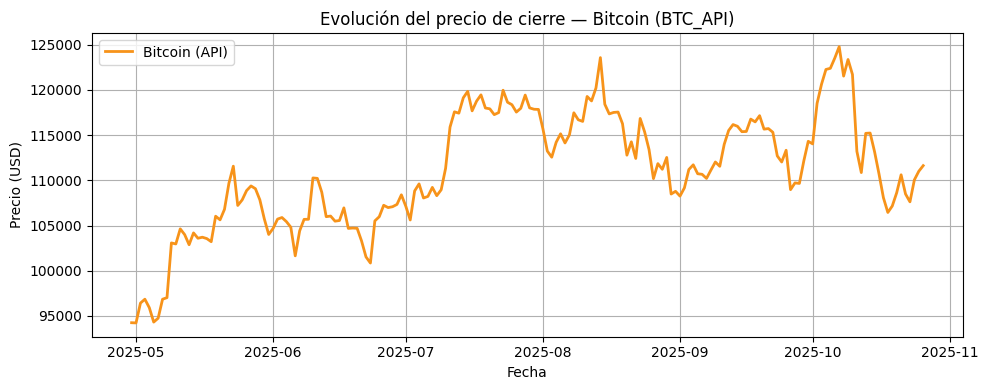

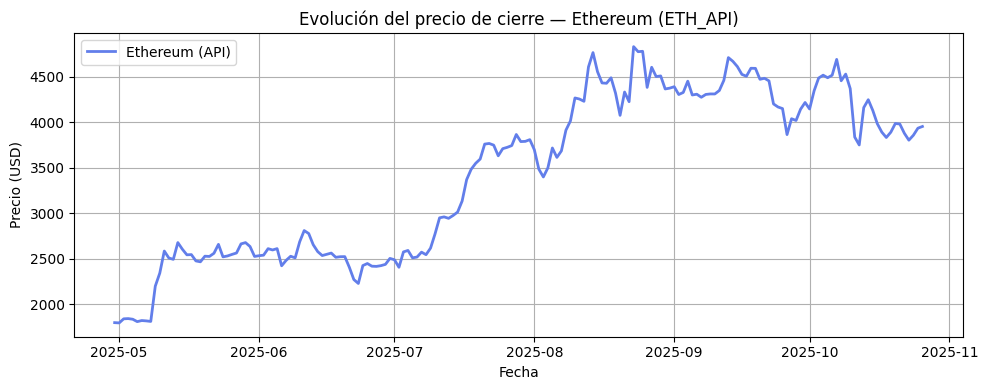

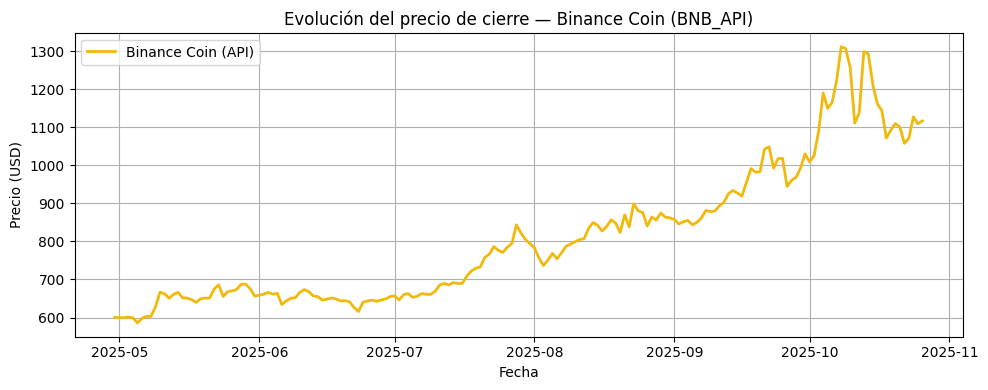

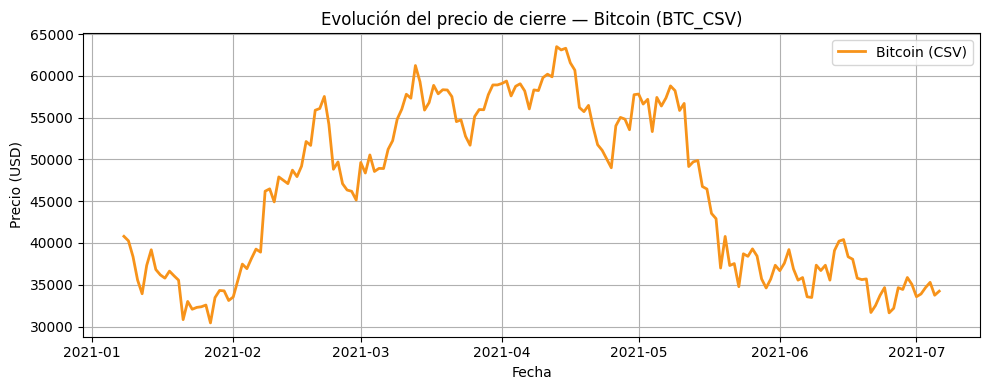

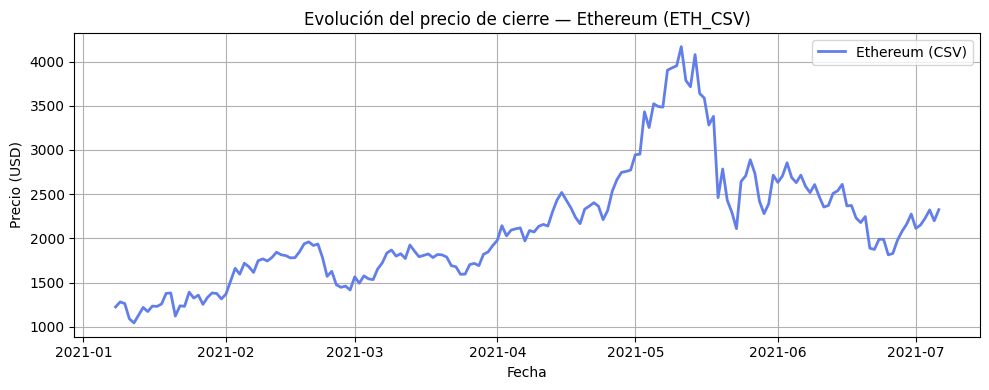

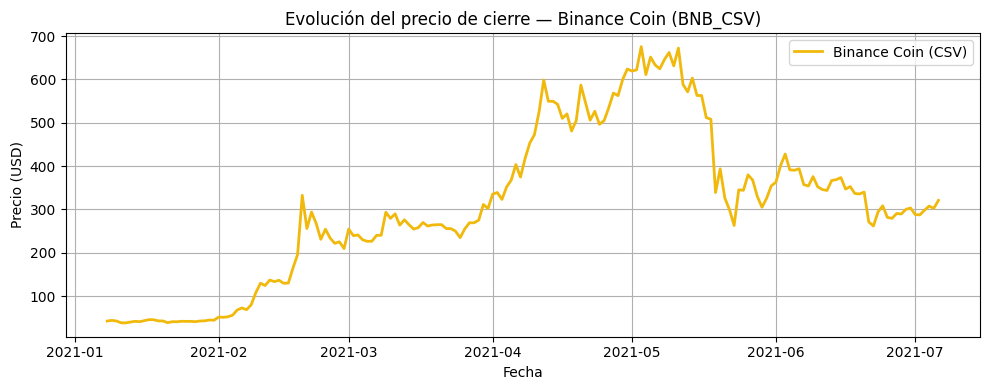

In [33]:
def plot_crypto_price(df, moneda, color="#222", label=None, days=None):

    data = df.copy()
    if days is not None and days < len(data):
        data = data.tail(days)
    if not label:
        label = moneda
    
    plt.figure(figsize=(10, 4))
    plt.plot(data["date"], data["close"], color=color, label=label, linewidth=2)
    plt.title(f"Evolución del precio de cierre — {moneda}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_crypto_price(btc_api, "Bitcoin (BTC_API)", color="#F7931A", label="Bitcoin (API)", days=180)
plot_crypto_price(eth_api, "Ethereum (ETH_API)", color="#627EEA", label="Ethereum (API)", days=180)
plot_crypto_price(bnb_api, "Binance Coin (BNB_API)", color="#F0B90B", label="Binance Coin (API)", days=180)
plot_crypto_price(btc_csv, "Bitcoin (BTC_CSV)", color="#F7931A", label="Bitcoin (CSV)", days=180)
plot_crypto_price(eth_csv, "Ethereum (ETH_CSV)", color="#627EEA", label="Ethereum (CSV)", days=180)
plot_crypto_price(bnb_csv, "Binance Coin (BNB_CSV)", color="#F0B90B", label="Binance Coin (CSV)", days=180)

## Análisis visual del volumen diario transado de las criptomonedas

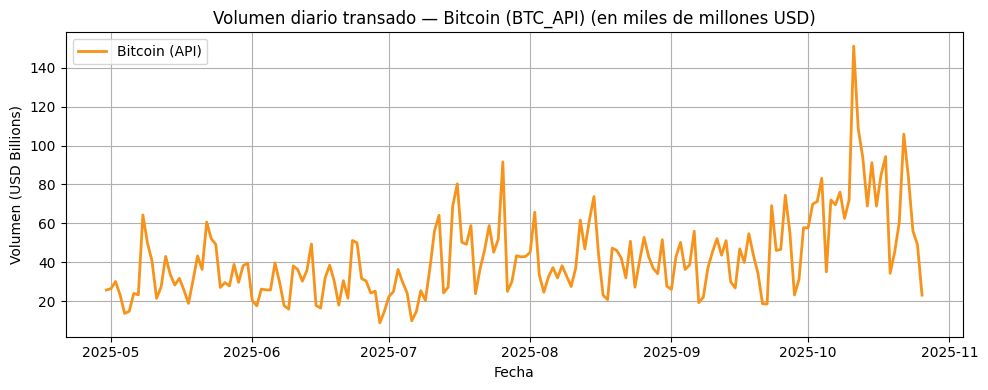

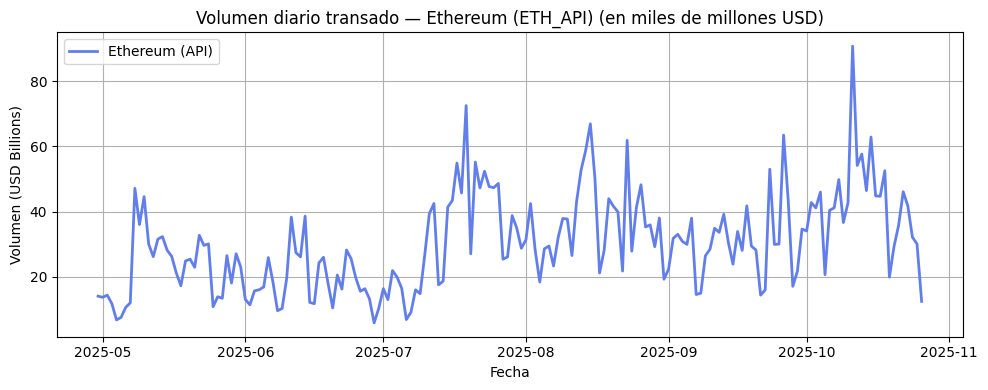

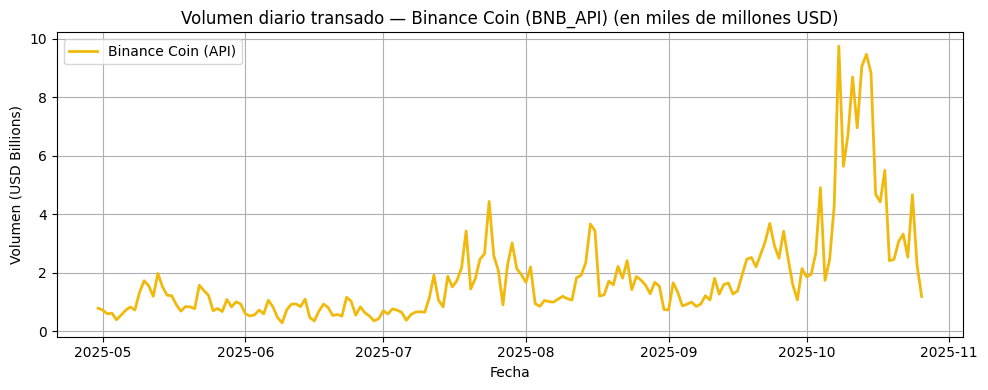

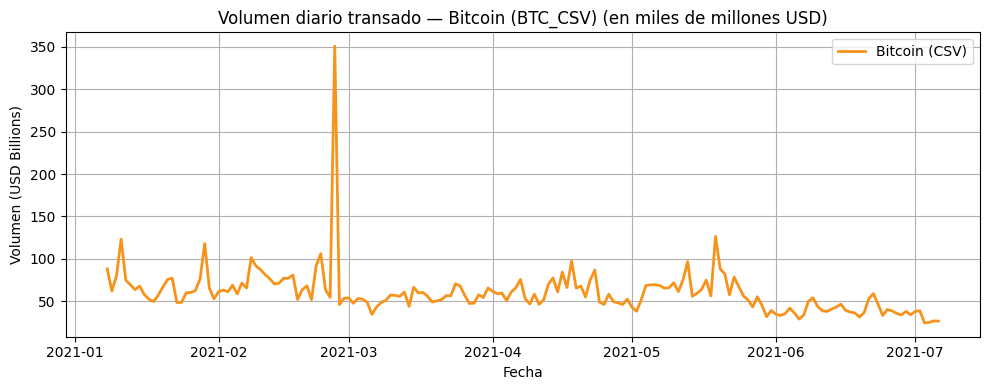

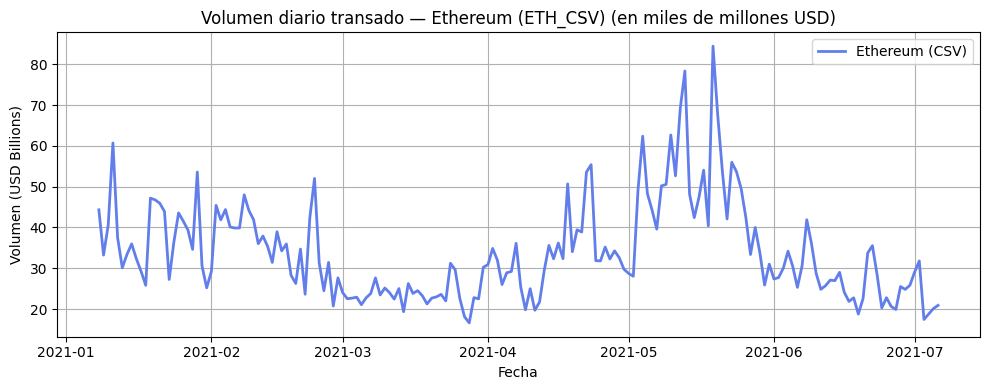

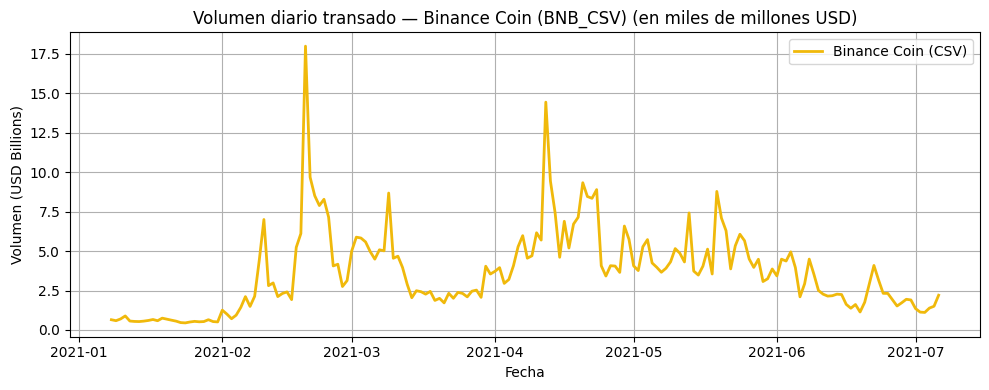

In [34]:
def plot_crypto_volume(df, moneda, color="#222", label=None, days=None):

    data = df.copy()
    if days is not None and days < len(data):
        data = data.tail(days)
    if not label:
        label = moneda
    
    plt.figure(figsize=(10, 4))
    plt.plot(data["date"], data["volume"]/1e9, color=color, label=label, linewidth=2)
    plt.title(f"Volumen diario transado — {moneda} (en miles de millones USD)")
    plt.xlabel("Fecha")
    plt.ylabel("Volumen (USD Billions)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_crypto_volume(btc_api, "Bitcoin (BTC_API)", color="#F7931A", label="Bitcoin (API)", days=180)
plot_crypto_volume(eth_api, "Ethereum (ETH_API)", color="#627EEA", label="Ethereum (API)", days=180)
plot_crypto_volume(bnb_api, "Binance Coin (BNB_API)", color="#F0B90B", label="Binance Coin (API)", days=180)
plot_crypto_volume(btc_csv, "Bitcoin (BTC_CSV)", color="#F7931A", label="Bitcoin (CSV)", days=180)
plot_crypto_volume(eth_csv, "Ethereum (ETH_CSV)", color="#627EEA", label="Ethereum (CSV)", days=180)
plot_crypto_volume(bnb_csv, "Binance Coin (BNB_CSV)", color="#F0B90B", label="Binance Coin (CSV)", days=180)